In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   bat
   2   prato
   3   vercelli
   4   la_spezia
   5   bologna
   6   cagliari
   7   lodi
   8   pavia
   9   reggio_di_calabria
   10   taranto
   11   monza
   12   pordenone
   13   cosenza
   14   catania
   15   lecco
   16   grosseto
   17   arezzo
   18   campobasso
   19   agrigento
   20   milano
   21   pisa
   22   avellino
   23   verbania
   24   mantova
   25   bolzano
   26   frosinone
   27   modena
   28   brescia
   29   cuneo
   30   teramo
   31   ragusa
   32   macerata
   33   imperia
   34   palermo
   35   forli
   36   roma
   37   chieti
   38   parma
   39   viterbo
   40   ferrara
   41   livorno
   42   isernia
   43   napoli
   44   padova
   45   latina
   46   siracusa
   47   venezia
   48   rovigo
   49   salerno
   50   reggio_nell_emilia
   51   pescara
   52   sondrio
   53   fermo
   54   sassari
   55   pistoia
   56   novara
   57   ancona
   58   matera
   59   r

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 bat
2 prato
3 vercelli
4 la_spezia
5 bologna
6 cagliari
7 lodi
8 pavia
9 reggio_di_calabria
10 taranto
11 monza
12 pordenone
13 cosenza
14 catania
15 lecco
16 grosseto
17 arezzo
18 campobasso
19 agrigento
20 milano
21 pisa
22 avellino
23 verbania
24 mantova
25 bolzano
26 frosinone
27 modena
28 brescia
29 cuneo
30 teramo
31 ragusa
32 macerata
33 imperia
34 palermo
35 forli
36 roma
37 chieti
38 parma
39 viterbo
40 ferrara
41 livorno
42 napoli
43 padova
44 latina
45 siracusa
46 venezia
47 rovigo
48 salerno
49 reggio_nell_emilia
50 pescara
51 sondrio
52 fermo
53 sassari
54 pistoia
55 novara
56 ancona
57 matera
58 rimini
59 caserta
60 lucca
61 varese
62 massa
63 biella
64 benevento
65 belluno
66 oristano
67 caltanissetta
68 terni
69 cremona
70 potenza
71 treviso
72 crotone
73 gorizia
74 siena
75 messina
76 ravenna
77 firenze
78 catanzaro
79 torino
80 alessandria
81 lecce
82 verona
83 enna
84 udine
85 vicenza
86 trapani
87 nuoro
88 brindisi
89 l_aquila
90 como
91 foggia
92 perugia
93 piace

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35648  0.02559 
    Test set average RMSE:  0.96115  0.09265 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34849
                       R2:  0.94443


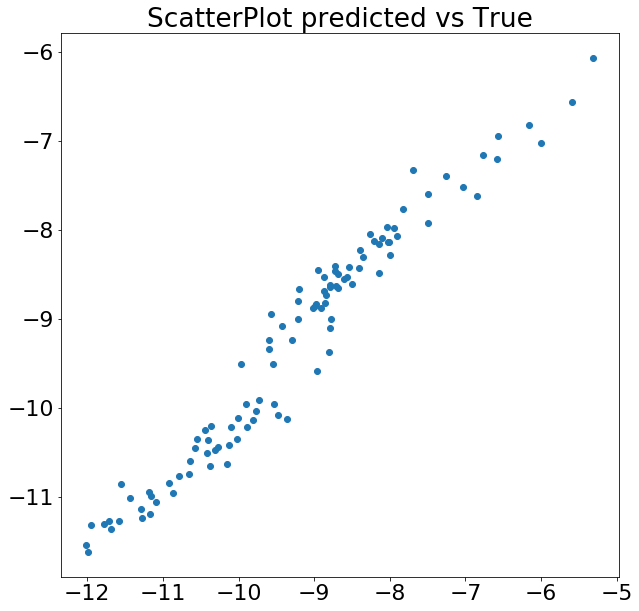

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02941
Feature:               commutersdensity, Score: 0.01259
Feature:                         depriv, Score: 0.02481
Feature:                            lat, Score: 0.66014
Feature:                 Ratio0200ver65, Score: 0.05661
Feature:         avg_wpm10_period1_2020, Score: 0.07189
Feature:           avg_wno_period1_2020, Score: 0.06469
Feature:         avg_wpans_period1_2020, Score: 0.02661
Feature:          avg_wso2_period1_2020, Score: 0.02580
Feature:                  randomfeature, Score: 0.02745


<Figure size 432x288 with 0 Axes>

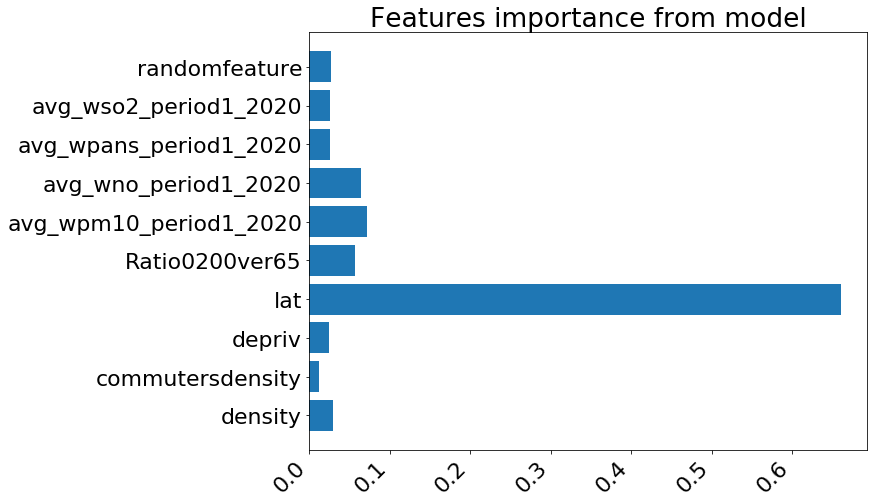

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04507 +/- 0.00395
Feature:               commutersdensity, Score: 0.02495 +/- 0.00313
Feature:                         depriv, Score: 0.04435 +/- 0.00401
Feature:                            lat, Score: 2.74777 +/- 0.33041
Feature:                 Ratio0200ver65, Score: 0.09446 +/- 0.01511
Feature:         avg_wpm10_period1_2020, Score: 0.20110 +/- 0.02878
Feature:           avg_wno_period1_2020, Score: 0.21975 +/- 0.02909
Feature:         avg_wpans_period1_2020, Score: 0.04835 +/- 0.00580
Feature:          avg_wso2_period1_2020, Score: 0.09358 +/- 0.01567
Feature:                  randomfeature, Score: 0.05568 +/- 0.00643


<Figure size 432x288 with 0 Axes>

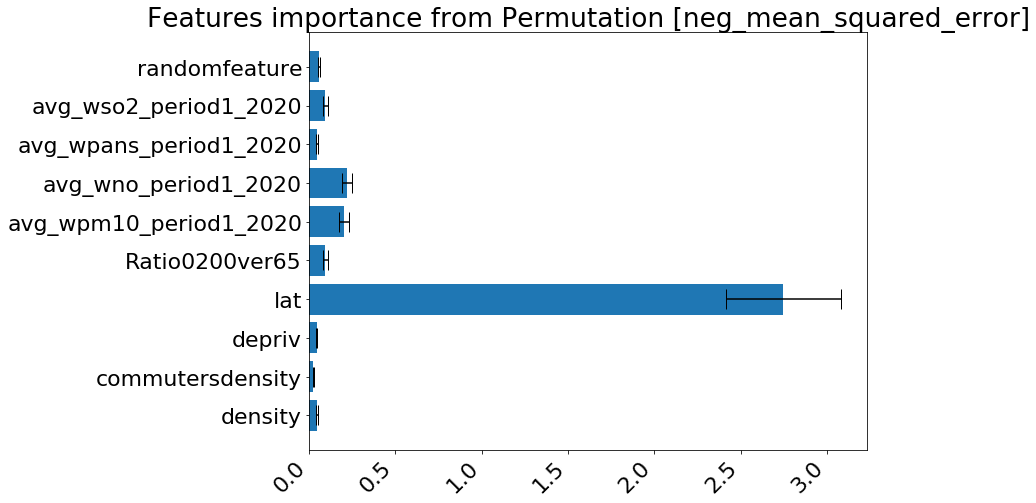

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02063 +/- 0.00181
Feature:               commutersdensity, Score: 0.01142 +/- 0.00143
Feature:                         depriv, Score: 0.02029 +/- 0.00183
Feature:                            lat, Score: 1.25742 +/- 0.15120
Feature:                 Ratio0200ver65, Score: 0.04323 +/- 0.00691
Feature:         avg_wpm10_period1_2020, Score: 0.09202 +/- 0.01317
Feature:           avg_wno_period1_2020, Score: 0.10056 +/- 0.01331
Feature:         avg_wpans_period1_2020, Score: 0.02213 +/- 0.00265
Feature:          avg_wso2_period1_2020, Score: 0.04282 +/- 0.00717
Feature:                  randomfeature, Score: 0.02548 +/- 0.00294


<Figure size 432x288 with 0 Axes>

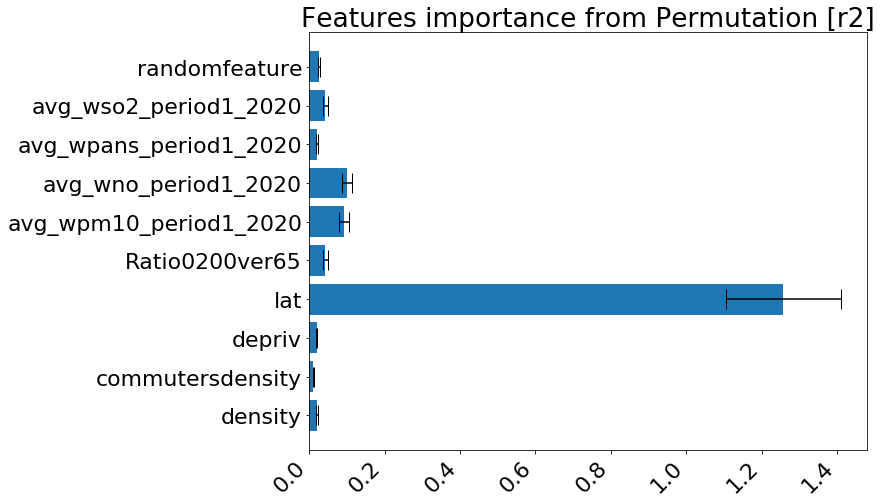

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01008 +/- 0.02511
Feature:               commutersdensity, Score: 0.00016 +/- 0.00855
Feature:                         depriv, Score: -0.03600 +/- 0.02774
Feature:                            lat, Score: 2.23229 +/- 0.65062
Feature:                 Ratio0200ver65, Score: -0.01952 +/- 0.05193
Feature:         avg_wpm10_period1_2020, Score: 0.00043 +/- 0.02174
Feature:           avg_wno_period1_2020, Score: 0.01774 +/- 0.04058
Feature:         avg_wpans_period1_2020, Score: 0.01077 +/- 0.01214
Feature:          avg_wso2_period1_2020, Score: -0.00138 +/- 0.01710
Feature:                  randomfeature, Score: -0.02716 +/- 0.03422


<Figure size 432x288 with 0 Axes>

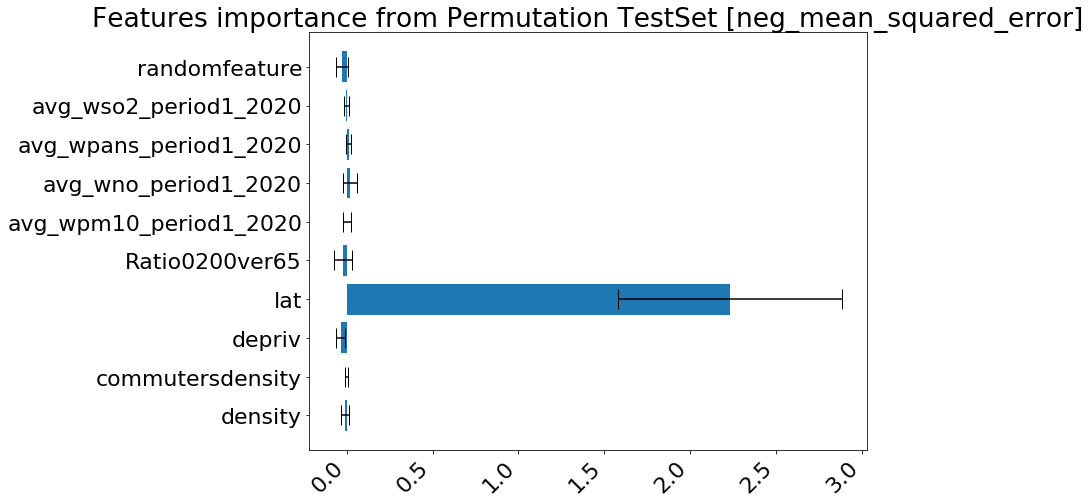

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00540 +/- 0.01345
Feature:               commutersdensity, Score: 0.00008 +/- 0.00458
Feature:                         depriv, Score: -0.01927 +/- 0.01485
Feature:                            lat, Score: 1.19527 +/- 0.34837
Feature:                 Ratio0200ver65, Score: -0.01045 +/- 0.02781
Feature:         avg_wpm10_period1_2020, Score: 0.00023 +/- 0.01164
Feature:           avg_wno_period1_2020, Score: 0.00950 +/- 0.02173
Feature:         avg_wpans_period1_2020, Score: 0.00577 +/- 0.00650
Feature:          avg_wso2_period1_2020, Score: -0.00074 +/- 0.00916
Feature:                  randomfeature, Score: -0.01454 +/- 0.01832


<Figure size 432x288 with 0 Axes>

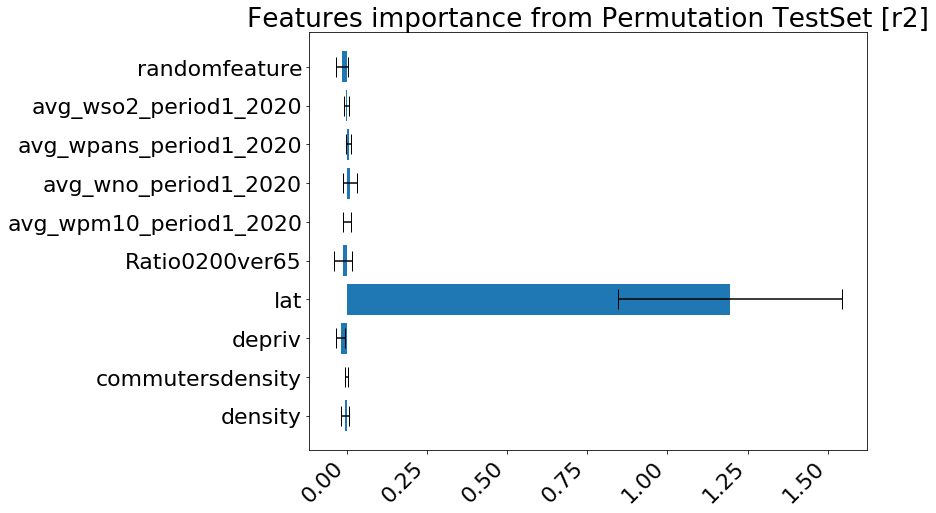

<Figure size 720x720 with 0 Axes>

((0.35648147175876427, 0.025588057323792646),
 (0.9611509172253204, 0.09265402907370288),
 0.3484866903240793,
 {'density': 0.012607917992147777,
  'commutersdensity': 0.0069776389147526525,
  'depriv': 0.012404122110527752,
  'lat': 0.7685944414412377,
  'Ratio0200ver65': 0.026421800988956325,
  'avg_wpm10_period1_2020': 0.05624991755472372,
  'avg_wno_period1_2020': 0.061467927309545554,
  'avg_wpans_period1_2020': 0.013524959133006975,
  'avg_wso2_period1_2020': 0.026176522218207588,
  'randomfeature': 0.01557475233689405},
 {'density': 0.012607917992147803,
  'commutersdensity': 0.00697763891475268,
  'depriv': 0.01240412211052778,
  'lat': 0.7685944414412375,
  'Ratio0200ver65': 0.02642180098895635,
  'avg_wpm10_period1_2020': 0.05624991755472373,
  'avg_wno_period1_2020': 0.06146792730954555,
  'avg_wpans_period1_2020': 0.013524959133006999,
  'avg_wso2_period1_2020': 0.0261765222182076,
  'randomfeature': 0.015574752336894081},
 {'density': -0.004649495900671525,
  'commutersden

In [6]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [7]:
# here we test grid opt to get a model not overfitting 

importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

1  of  1200 Train RMSE:  0.3354378090099384
1  of  1200  Test RMSE:  1.0647844577220127
2  of  1200 Train RMSE:  0.32307761142394215
2  of  1200  Test RMSE:  1.0978696324101387
3  of  1200 Train RMSE:  0.4193653156090385
3  of  1200  Test RMSE:  1.060601701435241
4  of  1200 Train RMSE:  0.4478815364372578
4  of  1200  Test RMSE:  1.0833640032215182
5  of  1200 Train RMSE:  0.6429530232374189
5  of  1200  Test RMSE:  1.0353718600416877
6  of  1200 Train RMSE:  0.6809825386319527
6  of  1200  Test RMSE:  1.0707754642997307
7  of  1200 Train RMSE:  0.7616848335939628
7  of  1200  Test RMSE:  0.9904021286055017
8  of  1200 Train RMSE:  0.7977522949429952
8  of  1200  Test RMSE:  1.0827589083160623
9  of  1200 Train RMSE:  0.40506863788223085
9  of  1200  Test RMSE:  1.0566364406136466
10  of  1200 Train RMSE:  0.39751747016178635
10  of  1200  Test RMSE:  1.0734724532317925
11  of  1200 Train RMSE:  0.44056051256963924
11  of  1200  Test RMSE:  1.0659765146453815
12  of  1200 Train RMSE: 

Training set average RMSE:  0.78854  0.03837 
    Test set average RMSE:  0.91502  0.08242 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.77294
                       R2:  0.72661


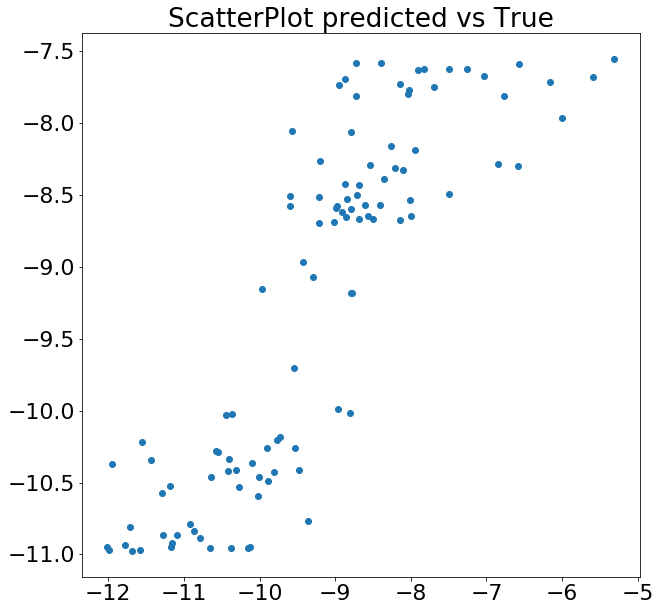

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.00438
Feature:               commutersdensity, Score: 0.00238
Feature:                         depriv, Score: 0.00415
Feature:                            lat, Score: 0.85915
Feature:                 Ratio0200ver65, Score: 0.02343
Feature:         avg_wpm10_period1_2020, Score: 0.01008
Feature:           avg_wno_period1_2020, Score: 0.08070
Feature:         avg_wpans_period1_2020, Score: 0.00181
Feature:          avg_wso2_period1_2020, Score: 0.00680
Feature:                  randomfeature, Score: 0.00714


<Figure size 432x288 with 0 Axes>

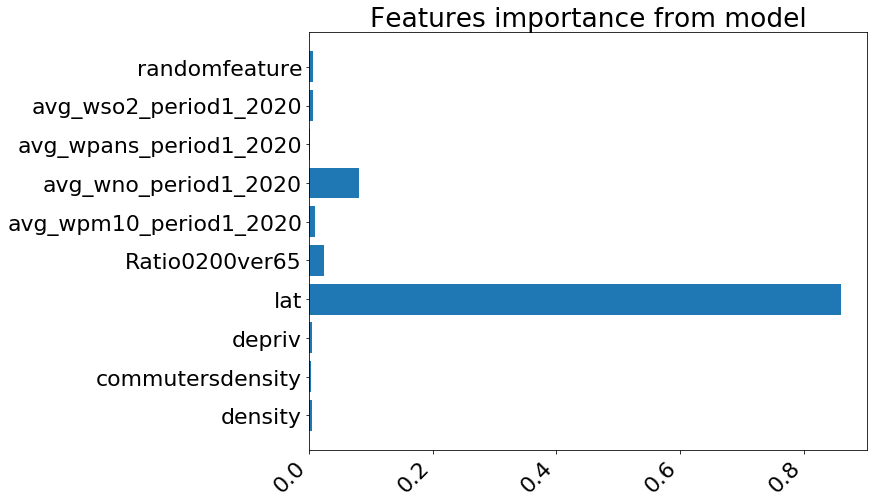

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04378 +/- 0.00348
Feature:               commutersdensity, Score: 0.02368 +/- 0.00259
Feature:                         depriv, Score: 0.04541 +/- 0.00360
Feature:                            lat, Score: 2.70583 +/- 0.32021
Feature:                 Ratio0200ver65, Score: 0.10230 +/- 0.01597
Feature:         avg_wpm10_period1_2020, Score: 0.17792 +/- 0.02108
Feature:           avg_wno_period1_2020, Score: 0.23035 +/- 0.03053
Feature:         avg_wpans_period1_2020, Score: 0.05072 +/- 0.00555
Feature:          avg_wso2_period1_2020, Score: 0.08052 +/- 0.01479
Feature:                  randomfeature, Score: 0.06206 +/- 0.00753


<Figure size 432x288 with 0 Axes>

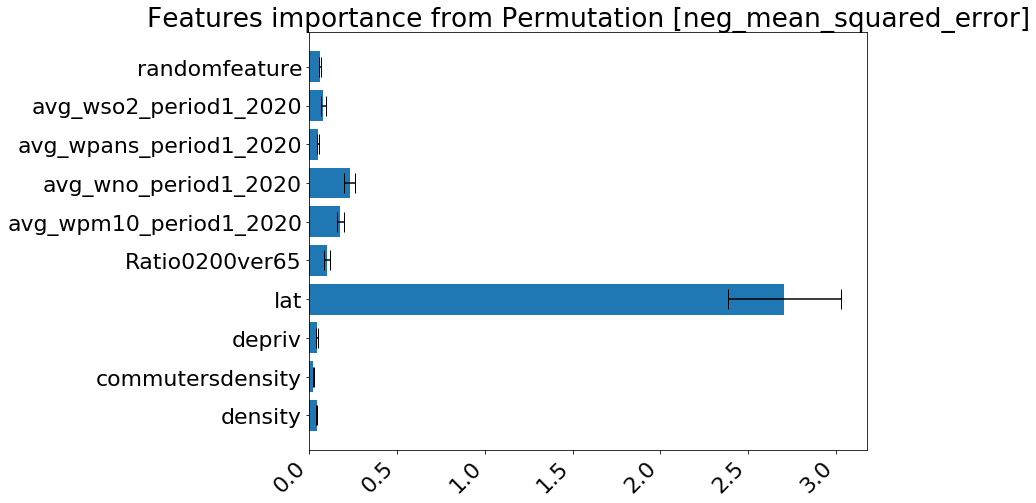

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02003 +/- 0.00159
Feature:               commutersdensity, Score: 0.01084 +/- 0.00118
Feature:                         depriv, Score: 0.02078 +/- 0.00165
Feature:                            lat, Score: 1.23822 +/- 0.14653
Feature:                 Ratio0200ver65, Score: 0.04681 +/- 0.00731
Feature:         avg_wpm10_period1_2020, Score: 0.08142 +/- 0.00965
Feature:           avg_wno_period1_2020, Score: 0.10541 +/- 0.01397
Feature:         avg_wpans_period1_2020, Score: 0.02321 +/- 0.00254
Feature:          avg_wso2_period1_2020, Score: 0.03685 +/- 0.00677
Feature:                  randomfeature, Score: 0.02840 +/- 0.00344


<Figure size 432x288 with 0 Axes>

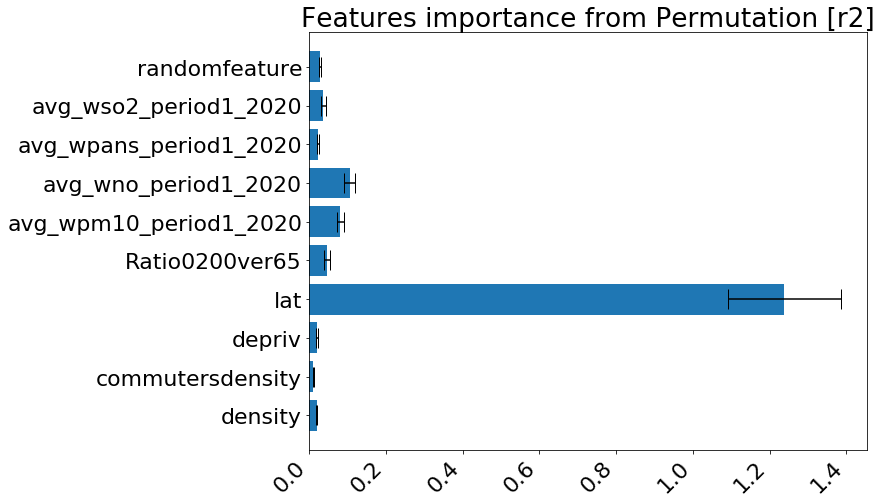

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00044 +/- 0.01895
Feature:               commutersdensity, Score: 0.00327 +/- 0.01071
Feature:                         depriv, Score: -0.02471 +/- 0.01890
Feature:                            lat, Score: 2.13111 +/- 0.60407
Feature:                 Ratio0200ver65, Score: -0.01917 +/- 0.05486
Feature:         avg_wpm10_period1_2020, Score: -0.00387 +/- 0.02280
Feature:           avg_wno_period1_2020, Score: -0.01917 +/- 0.04233
Feature:         avg_wpans_period1_2020, Score: 0.02301 +/- 0.00914
Feature:          avg_wso2_period1_2020, Score: 0.02430 +/- 0.01482
Feature:                  randomfeature, Score: -0.04905 +/- 0.03930


<Figure size 432x288 with 0 Axes>

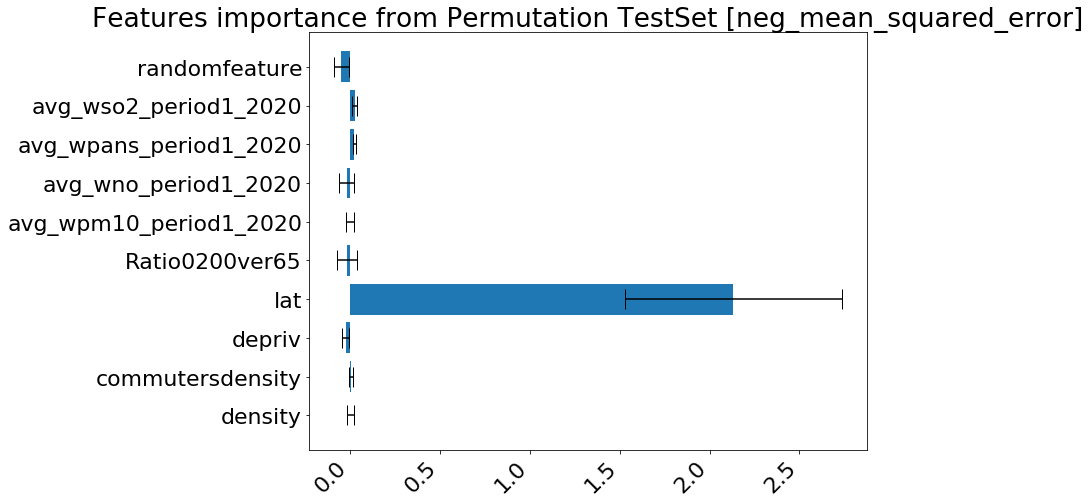

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00023 +/- 0.01015
Feature:               commutersdensity, Score: 0.00175 +/- 0.00573
Feature:                         depriv, Score: -0.01323 +/- 0.01012
Feature:                            lat, Score: 1.14109 +/- 0.32344
Feature:                 Ratio0200ver65, Score: -0.01026 +/- 0.02937
Feature:         avg_wpm10_period1_2020, Score: -0.00207 +/- 0.01221
Feature:           avg_wno_period1_2020, Score: -0.01027 +/- 0.02267
Feature:         avg_wpans_period1_2020, Score: 0.01232 +/- 0.00490
Feature:          avg_wso2_period1_2020, Score: 0.01301 +/- 0.00794
Feature:                  randomfeature, Score: -0.02626 +/- 0.02104


<Figure size 432x288 with 0 Axes>

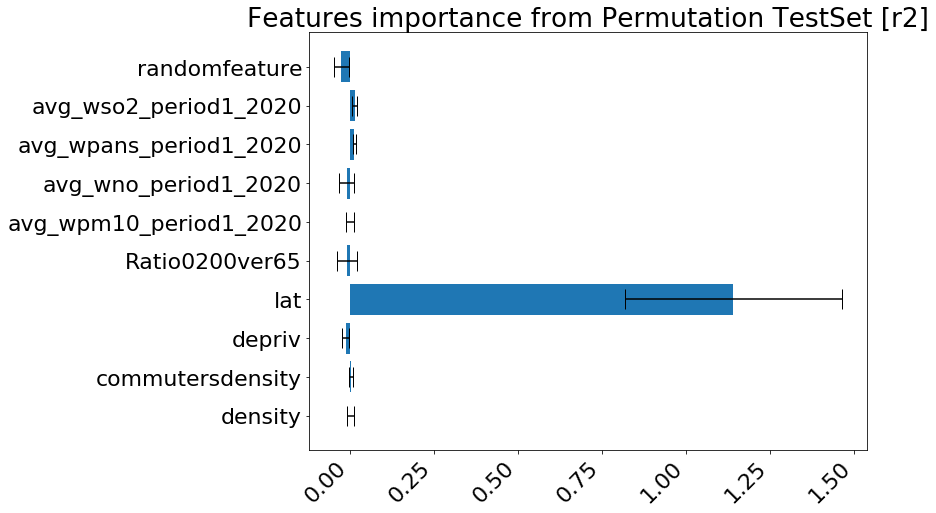

<Figure size 720x720 with 0 Axes>

((0.7885408389037122, 0.038369124218728026),
 (0.9150180713993251, 0.08242099669614866),
 0.7729370794079354,
 {'density': 0.01242774560685709,
  'commutersdensity': 0.006722151120041474,
  'depriv': 0.01289107044925122,
  'lat': 0.768142288048735,
  'Ratio0200ver65': 0.0290402626488407,
  'avg_wpm10_period1_2020': 0.05050903403046001,
  'avg_wno_period1_2020': 0.06539309011918995,
  'avg_wpans_period1_2020': 0.014397738139969106,
  'avg_wso2_period1_2020': 0.022859654653238016,
  'randomfeature': 0.017616965183417356},
 {'density': 0.012427745606857126,
  'commutersdensity': 0.0067221511200415114,
  'depriv': 0.01289107044925126,
  'lat': 0.7681422880487349,
  'Ratio0200ver65': 0.02904026264884072,
  'avg_wpm10_period1_2020': 0.05050903403046003,
  'avg_wno_period1_2020': 0.06539309011918999,
  'avg_wpans_period1_2020': 0.014397738139969137,
  'avg_wso2_period1_2020': 0.022859654653238057,
  'randomfeature': 0.017616965183417384},
 {'density': -0.00021181352633862932,
  'commutersdens

In [8]:
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=besthyperF)

Training set average RMSE:  0.38573  0.03219 
    Test set average RMSE:  1.04692  0.11525 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36914
                       R2:  0.93764


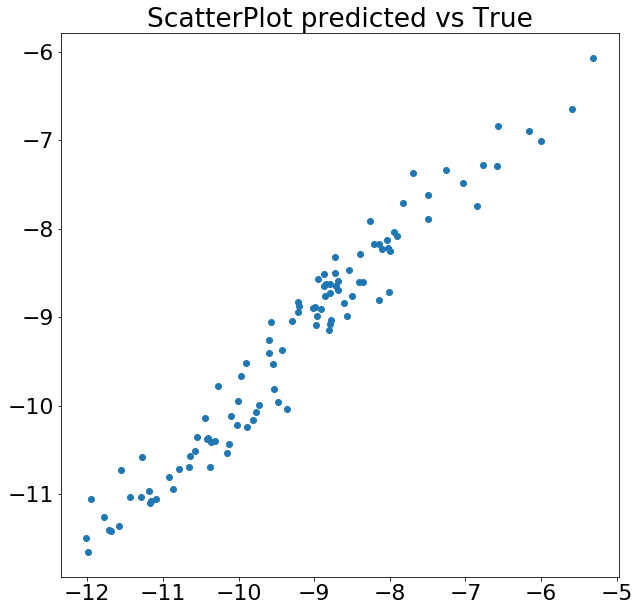

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03301
Feature:               commutersdensity, Score: 0.47863
Feature:                         depriv, Score: 0.04265
Feature:                 Ratio0200ver65, Score: 0.10065
Feature:         avg_wpm10_period1_2020, Score: 0.08356
Feature:           avg_wno_period1_2020, Score: 0.14355
Feature:         avg_wpans_period1_2020, Score: 0.03718
Feature:          avg_wso2_period1_2020, Score: 0.04784
Feature:                  randomfeature, Score: 0.03294


<Figure size 432x288 with 0 Axes>

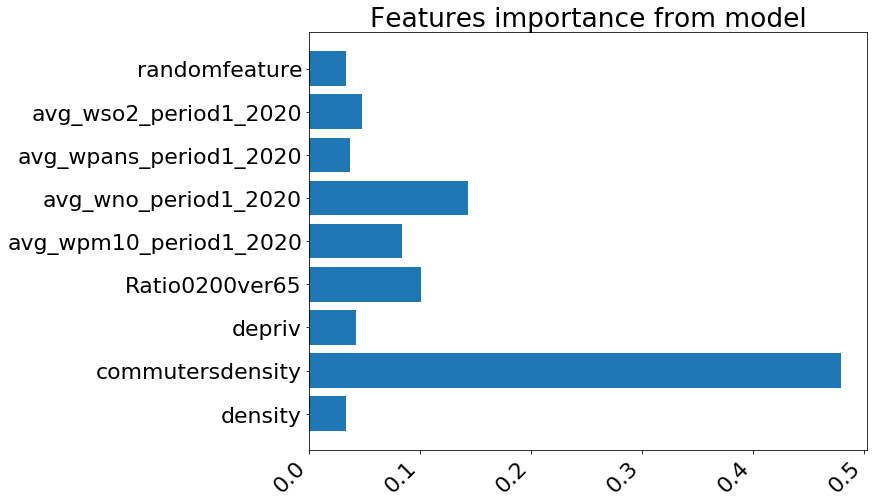

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05140 +/- 0.00520
Feature:               commutersdensity, Score: 1.70270 +/- 0.25059
Feature:                         depriv, Score: 0.06715 +/- 0.00660
Feature:                 Ratio0200ver65, Score: 0.22835 +/- 0.03214
Feature:         avg_wpm10_period1_2020, Score: 0.23481 +/- 0.03179
Feature:           avg_wno_period1_2020, Score: 0.41145 +/- 0.05556
Feature:         avg_wpans_period1_2020, Score: 0.07063 +/- 0.00951
Feature:          avg_wso2_period1_2020, Score: 0.12555 +/- 0.01938
Feature:                  randomfeature, Score: 0.05355 +/- 0.00564


<Figure size 432x288 with 0 Axes>

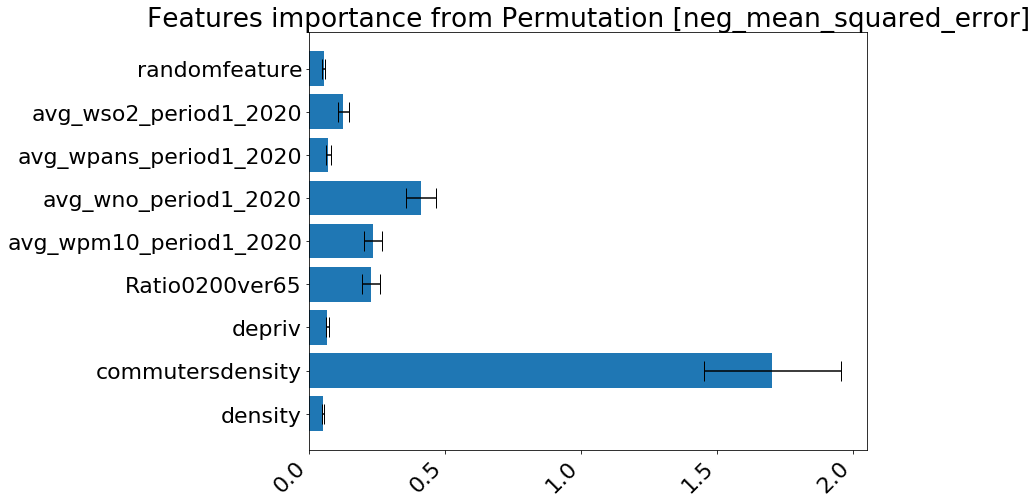

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02352 +/- 0.00238
Feature:               commutersdensity, Score: 0.77918 +/- 0.11467
Feature:                         depriv, Score: 0.03073 +/- 0.00302
Feature:                 Ratio0200ver65, Score: 0.10450 +/- 0.01471
Feature:         avg_wpm10_period1_2020, Score: 0.10745 +/- 0.01455
Feature:           avg_wno_period1_2020, Score: 0.18829 +/- 0.02542
Feature:         avg_wpans_period1_2020, Score: 0.03232 +/- 0.00435
Feature:          avg_wso2_period1_2020, Score: 0.05746 +/- 0.00887
Feature:                  randomfeature, Score: 0.02451 +/- 0.00258


<Figure size 432x288 with 0 Axes>

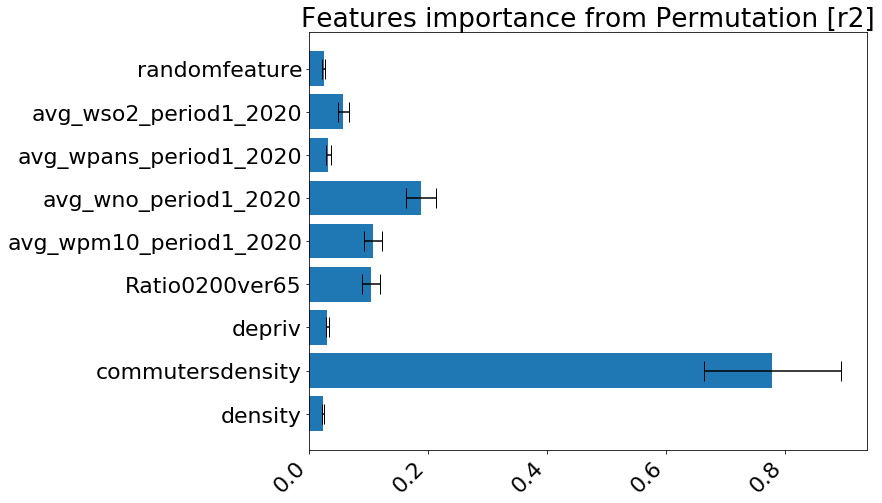

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00338 +/- 0.03798
Feature:               commutersdensity, Score: 0.80430 +/- 0.28112
Feature:                         depriv, Score: -0.01280 +/- 0.04290
Feature:                 Ratio0200ver65, Score: -0.02290 +/- 0.13623
Feature:         avg_wpm10_period1_2020, Score: 0.03056 +/- 0.08784
Feature:           avg_wno_period1_2020, Score: 0.06161 +/- 0.07897
Feature:         avg_wpans_period1_2020, Score: 0.02041 +/- 0.02579
Feature:          avg_wso2_period1_2020, Score: 0.02528 +/- 0.03021
Feature:                  randomfeature, Score: -0.08497 +/- 0.04091


<Figure size 432x288 with 0 Axes>

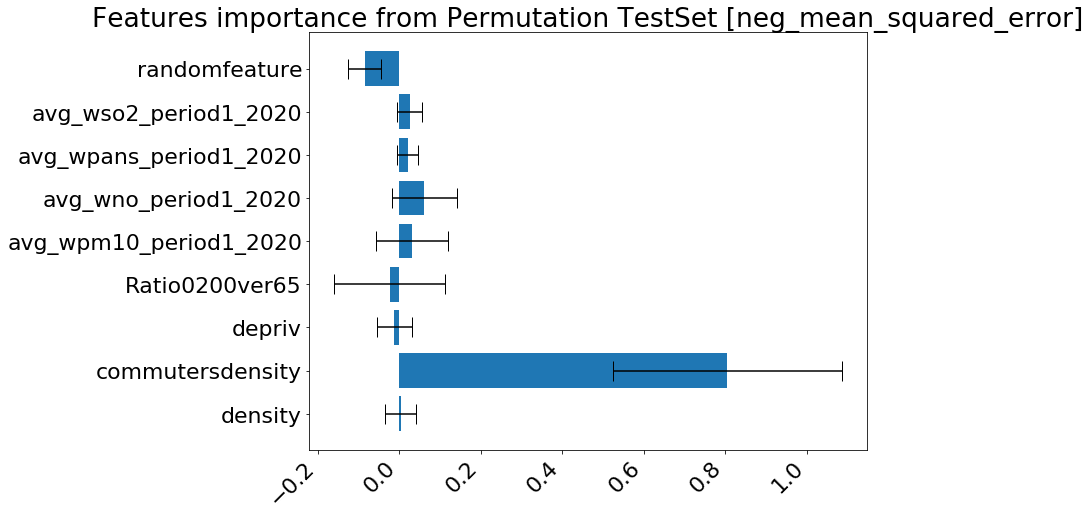

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00181 +/- 0.02033
Feature:               commutersdensity, Score: 0.43066 +/- 0.15053
Feature:                         depriv, Score: -0.00685 +/- 0.02297
Feature:                 Ratio0200ver65, Score: -0.01226 +/- 0.07294
Feature:         avg_wpm10_period1_2020, Score: 0.01636 +/- 0.04703
Feature:           avg_wno_period1_2020, Score: 0.03299 +/- 0.04229
Feature:         avg_wpans_period1_2020, Score: 0.01093 +/- 0.01381
Feature:          avg_wso2_period1_2020, Score: 0.01354 +/- 0.01617
Feature:                  randomfeature, Score: -0.04549 +/- 0.02190


<Figure size 432x288 with 0 Axes>

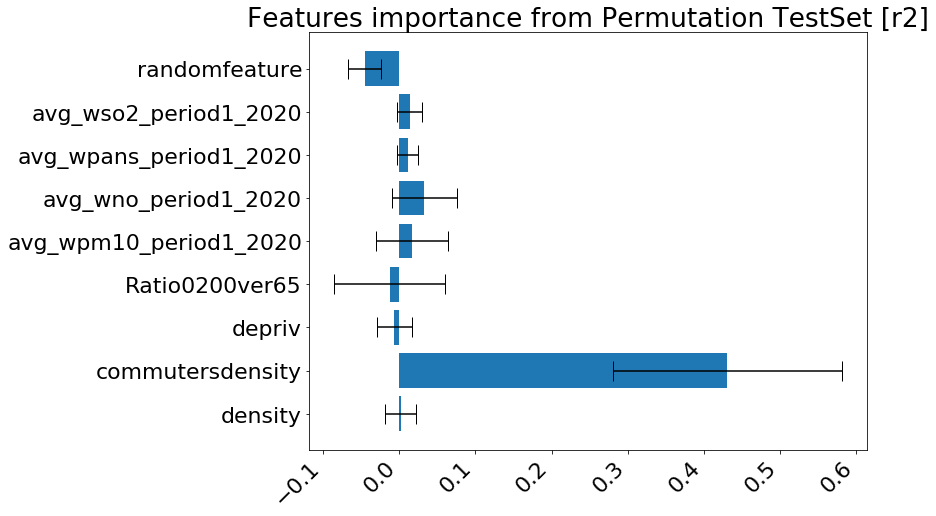

<Figure size 720x720 with 0 Axes>

((0.3857340694919165, 0.032190525395081576),
 (1.046919122595673, 0.11524988345431758),
 0.3691388423275126,
 {'density': 0.017448484291205015,
  'commutersdensity': 0.5780487032410371,
  'depriv': 0.022796679461314143,
  'Ratio0200ver65': 0.0775233923636489,
  'avg_wpm10_period1_2020': 0.07971654620894043,
  'avg_wno_period1_2020': 0.13968326814432996,
  'avg_wpans_period1_2020': 0.02397928324802788,
  'avg_wso2_period1_2020': 0.04262408470348635,
  'randomfeature': 0.01817955833801013},
 {'density': 0.017448484291205057,
  'commutersdensity': 0.578048703241037,
  'depriv': 0.022796679461314178,
  'Ratio0200ver65': 0.07752339236364893,
  'avg_wpm10_period1_2020': 0.07971654620894045,
  'avg_wno_period1_2020': 0.13968326814432996,
  'avg_wpans_period1_2020': 0.023979283248027918,
  'avg_wso2_period1_2020': 0.04262408470348639,
  'randomfeature': 0.01817955833801016},
 {'density': 0.00410241472079002,
  'commutersdensity': 0.9750486398097862,
  'depriv': -0.015511391707995842,
  'Ratio0

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


1  of  1200 Train RMSE:  0.42877137513719854
1  of  1200  Test RMSE:  0.8481475178259031
2  of  1200 Train RMSE:  0.4290121138617441
2  of  1200  Test RMSE:  0.8441913108728787
3  of  1200 Train RMSE:  0.5067914487639034
3  of  1200  Test RMSE:  0.8927755443911373
4  of  1200 Train RMSE:  0.5514185080694353
4  of  1200  Test RMSE:  0.8049868198352982
5  of  1200 Train RMSE:  0.8093011306949742
5  of  1200  Test RMSE:  0.8477483610431326
6  of  1200 Train RMSE:  0.8601095242122884
6  of  1200  Test RMSE:  0.8311794226276905
7  of  1200 Train RMSE:  0.9641535316116664
7  of  1200  Test RMSE:  0.8041785333597058
8  of  1200 Train RMSE:  1.0065685438525205
8  of  1200  Test RMSE:  0.8480709661445601
9  of  1200 Train RMSE:  0.5026688220097161
9  of  1200  Test RMSE:  0.8562868754765502
10  of  1200 Train RMSE:  0.5344548450023183
10  of  1200  Test RMSE:  0.7807181549629439
11  of  1200 Train RMSE:  0.5335352512210596
11  of  1200  Test RMSE:  0.8747725930276696
12  of  1200 Train RMSE:  0

Training set average RMSE:  0.72730  0.04089 
    Test set average RMSE:  1.02550  0.09750 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.67847
                       R2:  0.78935


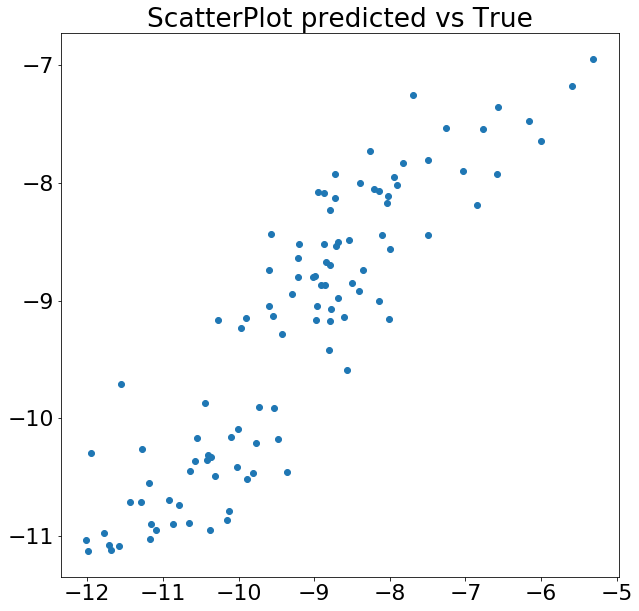

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.01627
Feature:               commutersdensity, Score: 0.59135
Feature:                         depriv, Score: 0.02346
Feature:                 Ratio0200ver65, Score: 0.07811
Feature:         avg_wpm10_period1_2020, Score: 0.09003
Feature:           avg_wno_period1_2020, Score: 0.13800
Feature:         avg_wpans_period1_2020, Score: 0.01700
Feature:          avg_wso2_period1_2020, Score: 0.03355
Feature:                  randomfeature, Score: 0.01224


<Figure size 432x288 with 0 Axes>

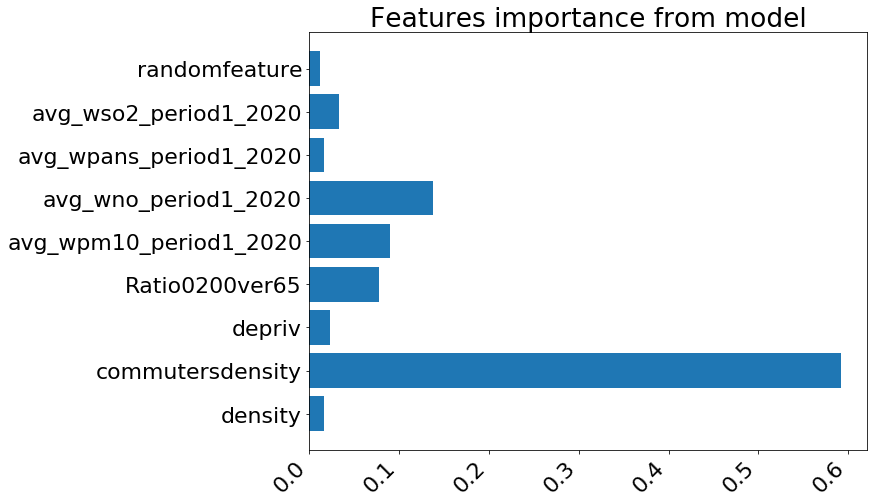

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05299 +/- 0.00495
Feature:               commutersdensity, Score: 1.73878 +/- 0.25420
Feature:                         depriv, Score: 0.07372 +/- 0.00838
Feature:                 Ratio0200ver65, Score: 0.24167 +/- 0.03368
Feature:         avg_wpm10_period1_2020, Score: 0.26305 +/- 0.03436
Feature:           avg_wno_period1_2020, Score: 0.35213 +/- 0.04829
Feature:         avg_wpans_period1_2020, Score: 0.08393 +/- 0.01150
Feature:          avg_wso2_period1_2020, Score: 0.08182 +/- 0.01047
Feature:                  randomfeature, Score: 0.05486 +/- 0.00618


<Figure size 432x288 with 0 Axes>

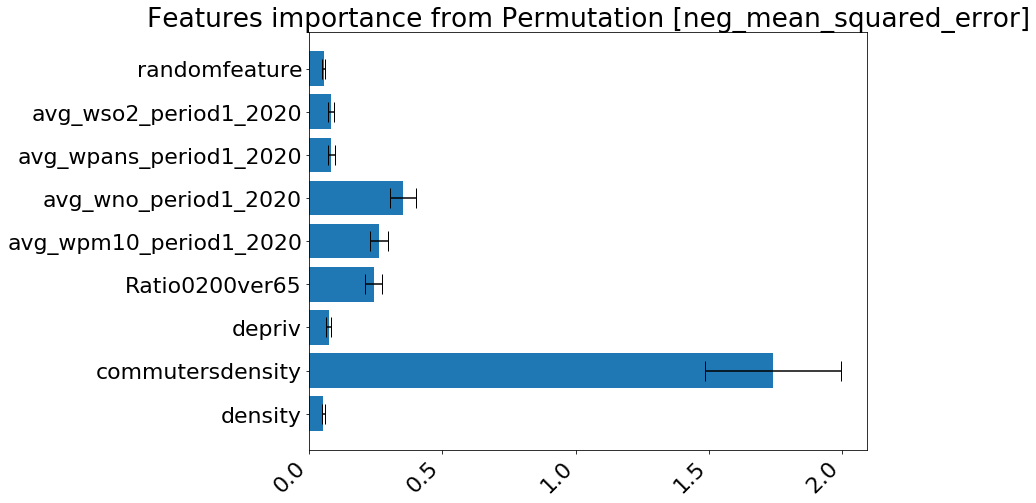

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02425 +/- 0.00227
Feature:               commutersdensity, Score: 0.79569 +/- 0.11633
Feature:                         depriv, Score: 0.03373 +/- 0.00384
Feature:                 Ratio0200ver65, Score: 0.11059 +/- 0.01541
Feature:         avg_wpm10_period1_2020, Score: 0.12038 +/- 0.01573
Feature:           avg_wno_period1_2020, Score: 0.16114 +/- 0.02210
Feature:         avg_wpans_period1_2020, Score: 0.03841 +/- 0.00526
Feature:          avg_wso2_period1_2020, Score: 0.03744 +/- 0.00479
Feature:                  randomfeature, Score: 0.02511 +/- 0.00283


<Figure size 432x288 with 0 Axes>

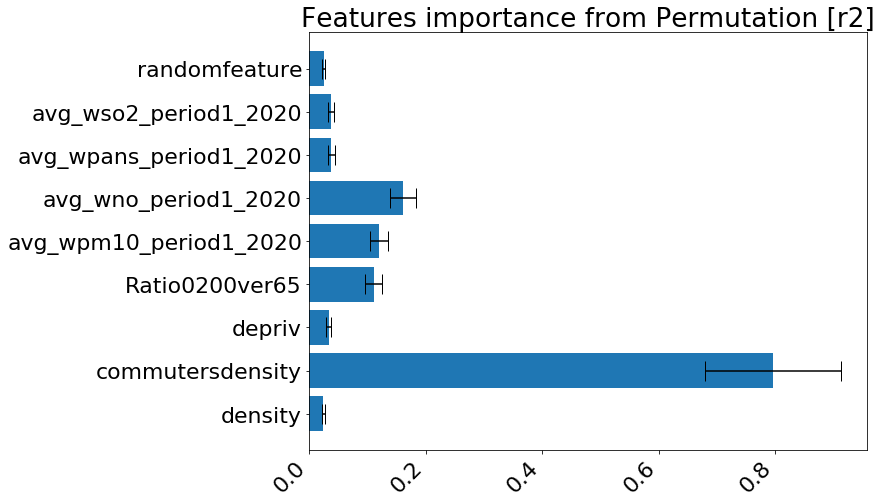

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.02810 +/- 0.02382
Feature:               commutersdensity, Score: 1.10903 +/- 0.35308
Feature:                         depriv, Score: -0.04486 +/- 0.04067
Feature:                 Ratio0200ver65, Score: -0.02598 +/- 0.11781
Feature:         avg_wpm10_period1_2020, Score: 0.00504 +/- 0.09319
Feature:           avg_wno_period1_2020, Score: 0.04784 +/- 0.07432
Feature:         avg_wpans_period1_2020, Score: 0.01930 +/- 0.03516
Feature:          avg_wso2_period1_2020, Score: 0.04929 +/- 0.03567
Feature:                  randomfeature, Score: -0.07580 +/- 0.04009


<Figure size 432x288 with 0 Axes>

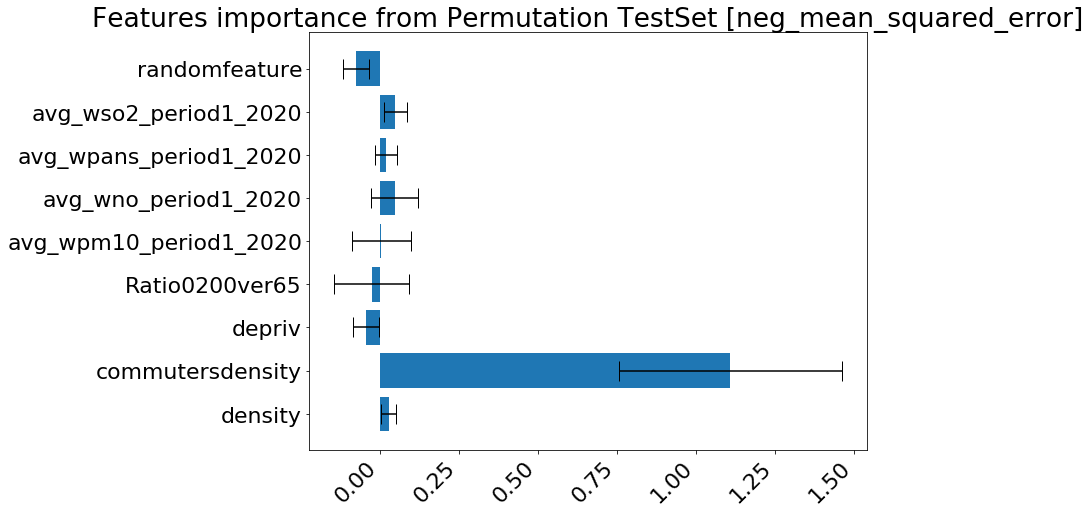

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.01505 +/- 0.01276
Feature:               commutersdensity, Score: 0.59383 +/- 0.18905
Feature:                         depriv, Score: -0.02402 +/- 0.02177
Feature:                 Ratio0200ver65, Score: -0.01391 +/- 0.06308
Feature:         avg_wpm10_period1_2020, Score: 0.00270 +/- 0.04990
Feature:           avg_wno_period1_2020, Score: 0.02561 +/- 0.03980
Feature:         avg_wpans_period1_2020, Score: 0.01033 +/- 0.01882
Feature:          avg_wso2_period1_2020, Score: 0.02639 +/- 0.01910
Feature:                  randomfeature, Score: -0.04059 +/- 0.02147


<Figure size 432x288 with 0 Axes>

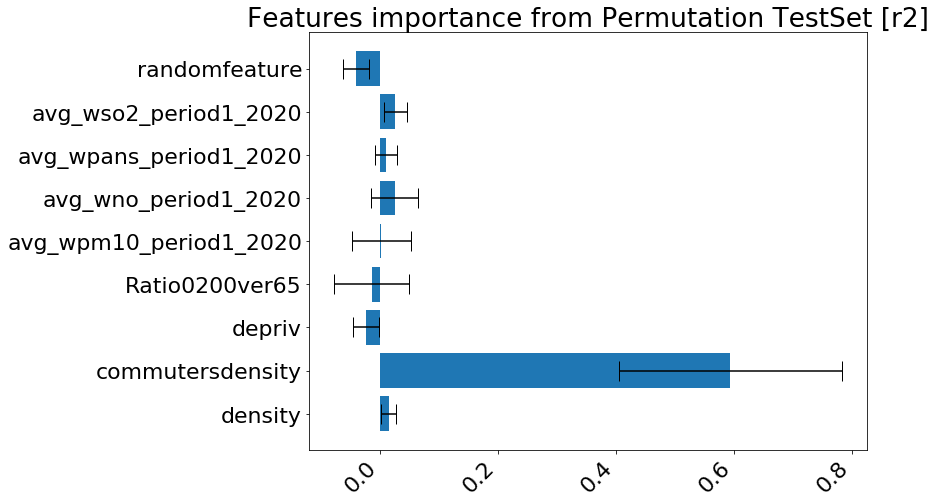

<Figure size 720x720 with 0 Axes>

((0.7272980163115578, 0.04089245596121163),
 (1.0255014095701842, 0.09749564319872885),
 0.6784706697647015,
 {'density': 0.01800731758098535,
  'commutersdensity': 0.5908266323171314,
  'depriv': 0.025048632626056246,
  'Ratio0200ver65': 0.08211942747334451,
  'avg_wpm10_period1_2020': 0.08938313848076375,
  'avg_wno_period1_2020': 0.11965213535455536,
  'avg_wpans_period1_2020': 0.02851814625596266,
  'avg_wso2_period1_2020': 0.02780292246397435,
  'randomfeature': 0.018641647447226444},
 {'density': 0.01800731758098532,
  'commutersdensity': 0.5908266323171314,
  'depriv': 0.025048632626056232,
  'Ratio0200ver65': 0.08211942747334451,
  'avg_wpm10_period1_2020': 0.08938313848076372,
  'avg_wno_period1_2020': 0.11965213535455538,
  'avg_wpans_period1_2020': 0.028518146255962638,
  'avg_wso2_period1_2020': 0.027802922463974318,
  'randomfeature': 0.018641647447226423},
 {'density': 0.02526932449579283,
  'commutersdensity': 0.9973602020944583,
  'depriv': -0.04033908672584382,
  'Rati

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=besthyperF )

Training set average RMSE:  0.42593  0.03156 
    Test set average RMSE:  1.07507  0.13179 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38922
                       R2:  0.93068


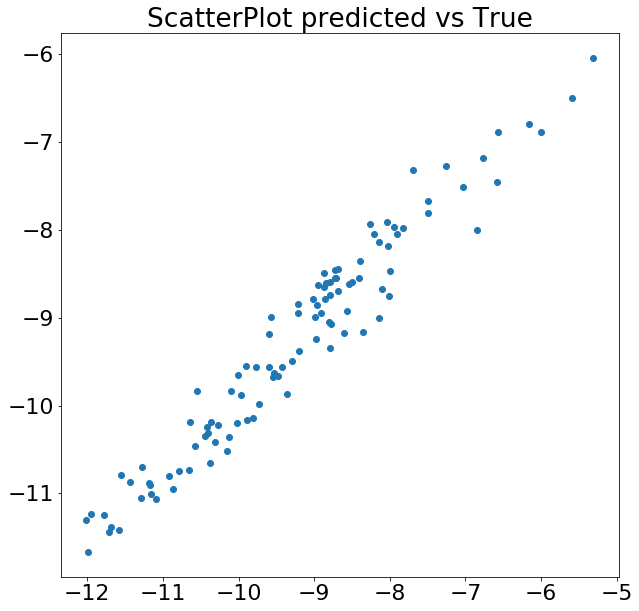

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03858
Feature:                         depriv, Score: 0.20303
Feature:                 Ratio0200ver65, Score: 0.08940
Feature:         avg_wpm10_period1_2020, Score: 0.20945
Feature:           avg_wno_period1_2020, Score: 0.30778
Feature:         avg_wpans_period1_2020, Score: 0.06113
Feature:          avg_wso2_period1_2020, Score: 0.06260
Feature:                  randomfeature, Score: 0.02803


<Figure size 432x288 with 0 Axes>

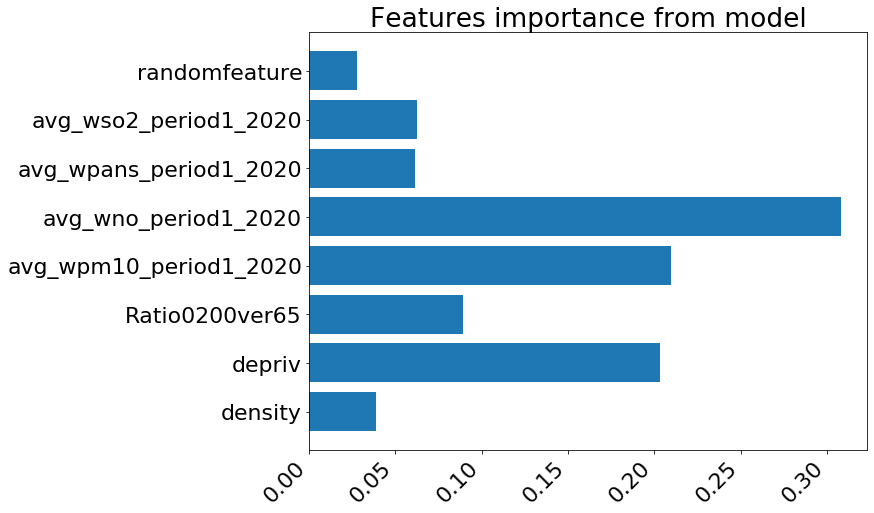

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05913 +/- 0.00689
Feature:                         depriv, Score: 0.56357 +/- 0.06644
Feature:                 Ratio0200ver65, Score: 0.20674 +/- 0.02796
Feature:         avg_wpm10_period1_2020, Score: 0.40790 +/- 0.05664
Feature:           avg_wno_period1_2020, Score: 1.02192 +/- 0.15103
Feature:         avg_wpans_period1_2020, Score: 0.14209 +/- 0.01783
Feature:          avg_wso2_period1_2020, Score: 0.11386 +/- 0.01365
Feature:                  randomfeature, Score: 0.05383 +/- 0.00660


<Figure size 432x288 with 0 Axes>

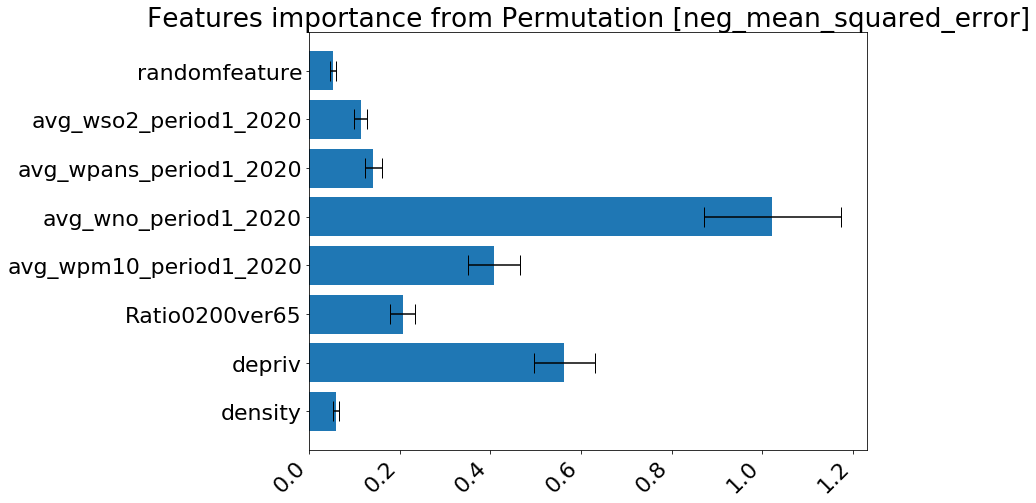

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02706 +/- 0.00315
Feature:                         depriv, Score: 0.25790 +/- 0.03040
Feature:                 Ratio0200ver65, Score: 0.09460 +/- 0.01279
Feature:         avg_wpm10_period1_2020, Score: 0.18666 +/- 0.02592
Feature:           avg_wno_period1_2020, Score: 0.46764 +/- 0.06912
Feature:         avg_wpans_period1_2020, Score: 0.06502 +/- 0.00816
Feature:          avg_wso2_period1_2020, Score: 0.05210 +/- 0.00625
Feature:                  randomfeature, Score: 0.02463 +/- 0.00302


<Figure size 432x288 with 0 Axes>

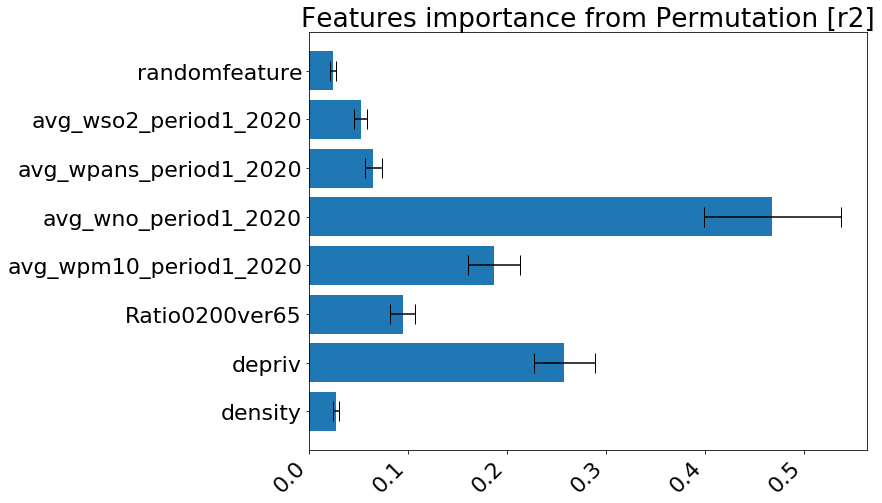

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00364 +/- 0.06792
Feature:                         depriv, Score: 0.39196 +/- 0.17101
Feature:                 Ratio0200ver65, Score: 0.04091 +/- 0.07912
Feature:         avg_wpm10_period1_2020, Score: 0.16056 +/- 0.20073
Feature:           avg_wno_period1_2020, Score: 0.31251 +/- 0.16454
Feature:         avg_wpans_period1_2020, Score: -0.05781 +/- 0.04820
Feature:          avg_wso2_period1_2020, Score: 0.06362 +/- 0.08073
Feature:                  randomfeature, Score: -0.04616 +/- 0.03864


<Figure size 432x288 with 0 Axes>

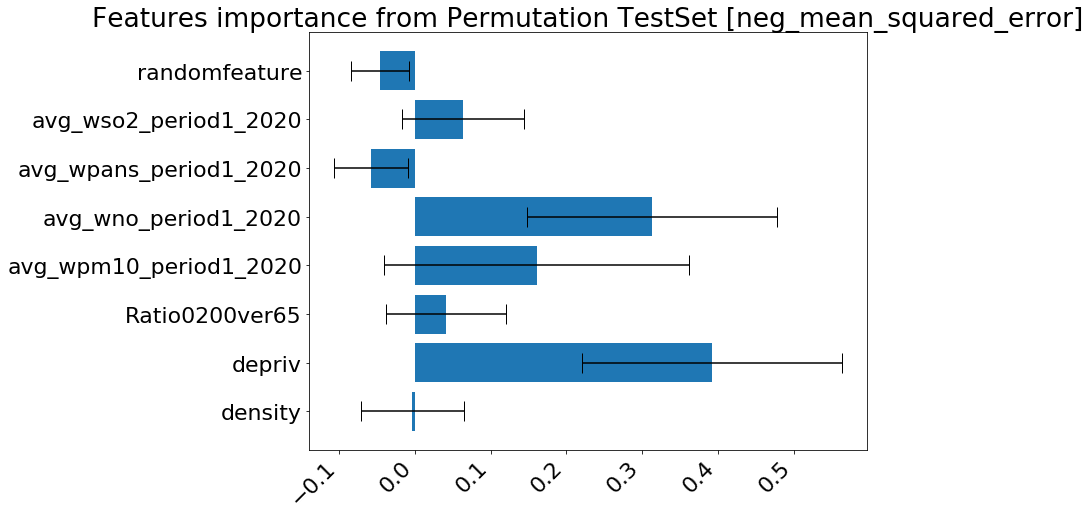

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00195 +/- 0.03637
Feature:                         depriv, Score: 0.20988 +/- 0.09157
Feature:                 Ratio0200ver65, Score: 0.02190 +/- 0.04236
Feature:         avg_wpm10_period1_2020, Score: 0.08597 +/- 0.10748
Feature:           avg_wno_period1_2020, Score: 0.16733 +/- 0.08810
Feature:         avg_wpans_period1_2020, Score: -0.03095 +/- 0.02581
Feature:          avg_wso2_period1_2020, Score: 0.03406 +/- 0.04323
Feature:                  randomfeature, Score: -0.02471 +/- 0.02069


<Figure size 432x288 with 0 Axes>

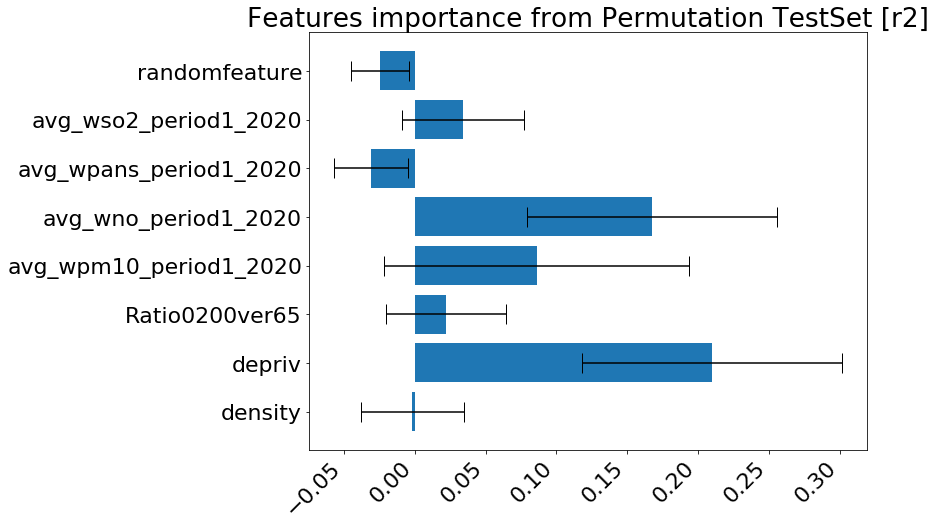

<Figure size 720x720 with 0 Axes>

((0.42592740306506877, 0.03156116676835217),
 (1.0750745638699086, 0.13179363510290573),
 0.3892160787685707,
 {'density': 0.02301604166077631,
  'depriv': 0.21937237669803822,
  'Ratio0200ver65': 0.08047222148024132,
  'avg_wpm10_period1_2020': 0.158774995322349,
  'avg_wno_period1_2020': 0.3977838294041336,
  'avg_wpans_period1_2020': 0.055310373361700846,
  'avg_wso2_period1_2020': 0.04431853424501725,
  'randomfeature': 0.02095162782774346},
 {'density': 0.02301604166077632,
  'depriv': 0.21937237669803814,
  'Ratio0200ver65': 0.08047222148024132,
  'avg_wpm10_period1_2020': 0.158774995322349,
  'avg_wno_period1_2020': 0.3977838294041334,
  'avg_wpans_period1_2020': 0.05531037336170084,
  'avg_wso2_period1_2020': 0.04431853424501724,
  'randomfeature': 0.020951627827743475},
 {'density': -0.0042185459515715435,
  'depriv': 0.4547375686066985,
  'Ratio0200ver65': 0.047458557962545014,
  'avg_wpm10_period1_2020': 0.18627774523013263,
  'avg_wno_period1_2020': 0.36255578786229403,
  '

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

print(besthyperF, best_diff, best_test_rmse, best_train_rmse)

1  of  1200 Train RMSE:  0.40523595247374783
1  of  1200  Test RMSE:  1.129032356551006
2  of  1200 Train RMSE:  0.39005576530242175
2  of  1200  Test RMSE:  1.094345909613067
3  of  1200 Train RMSE:  0.4802307753740327
3  of  1200  Test RMSE:  1.109023069482733
4  of  1200 Train RMSE:  0.5620077981826558
4  of  1200  Test RMSE:  1.1112716103591374
5  of  1200 Train RMSE:  0.7384190786724756
5  of  1200  Test RMSE:  1.135669164058462
6  of  1200 Train RMSE:  0.8242669705299612
6  of  1200  Test RMSE:  1.1311962890686444
7  of  1200 Train RMSE:  0.9246726390152066
7  of  1200  Test RMSE:  1.157903374955529
8  of  1200 Train RMSE:  1.014390560641561
8  of  1200  Test RMSE:  1.1419277558956082
9  of  1200 Train RMSE:  0.4759622732293608
9  of  1200  Test RMSE:  1.1346029860311437
10  of  1200 Train RMSE:  0.5280540832117028
10  of  1200  Test RMSE:  1.0956392121945346
11  of  1200 Train RMSE:  0.5037663020344912
11  of  1200  Test RMSE:  1.117225682161695
12  of  1200 Train RMSE:  0.57763

Training set average RMSE:  0.94428  0.05838 
    Test set average RMSE:  1.11242  0.12519 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.92099
                       R2:  0.61184


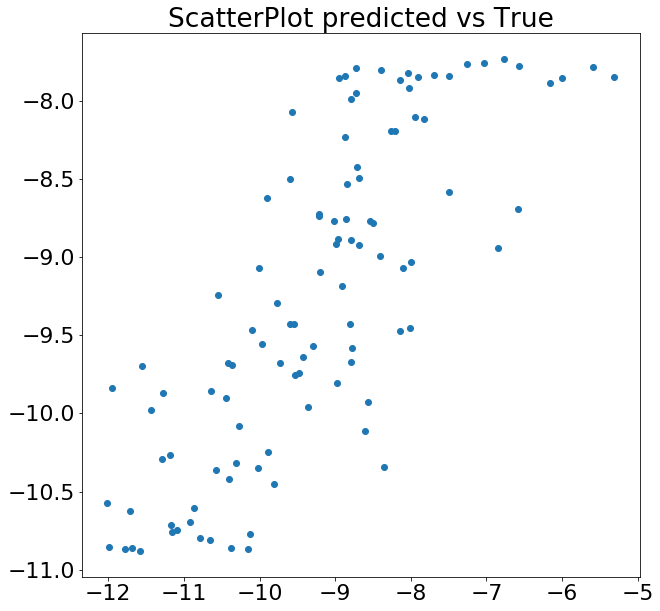

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.00956
Feature:                         depriv, Score: 0.23622
Feature:                 Ratio0200ver65, Score: 0.04622
Feature:         avg_wpm10_period1_2020, Score: 0.19163
Feature:           avg_wno_period1_2020, Score: 0.45001
Feature:         avg_wpans_period1_2020, Score: 0.02369
Feature:          avg_wso2_period1_2020, Score: 0.03419
Feature:                  randomfeature, Score: 0.00849


<Figure size 432x288 with 0 Axes>

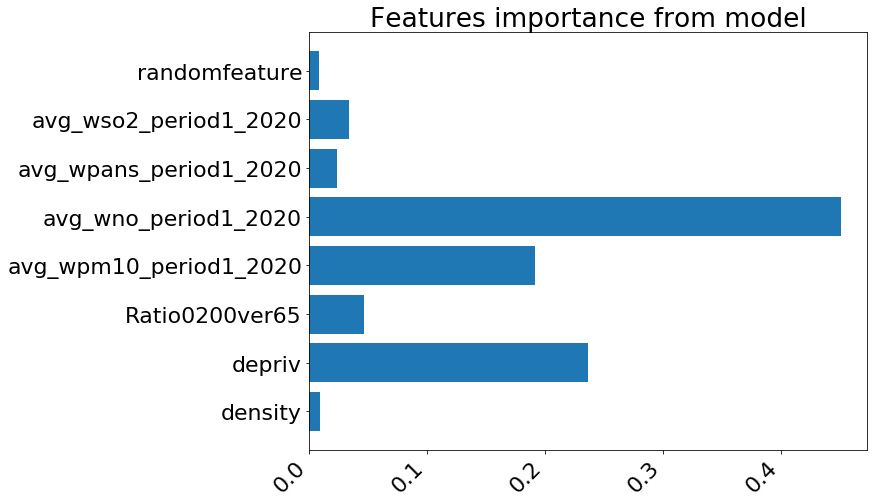

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07685 +/- 0.00843
Feature:                         depriv, Score: 0.69701 +/- 0.08815
Feature:                 Ratio0200ver65, Score: 0.18892 +/- 0.02418
Feature:         avg_wpm10_period1_2020, Score: 0.42779 +/- 0.05992
Feature:           avg_wno_period1_2020, Score: 0.82053 +/- 0.12327
Feature:         avg_wpans_period1_2020, Score: 0.12804 +/- 0.01348
Feature:          avg_wso2_period1_2020, Score: 0.10184 +/- 0.01066
Feature:                  randomfeature, Score: 0.05448 +/- 0.00604


<Figure size 432x288 with 0 Axes>

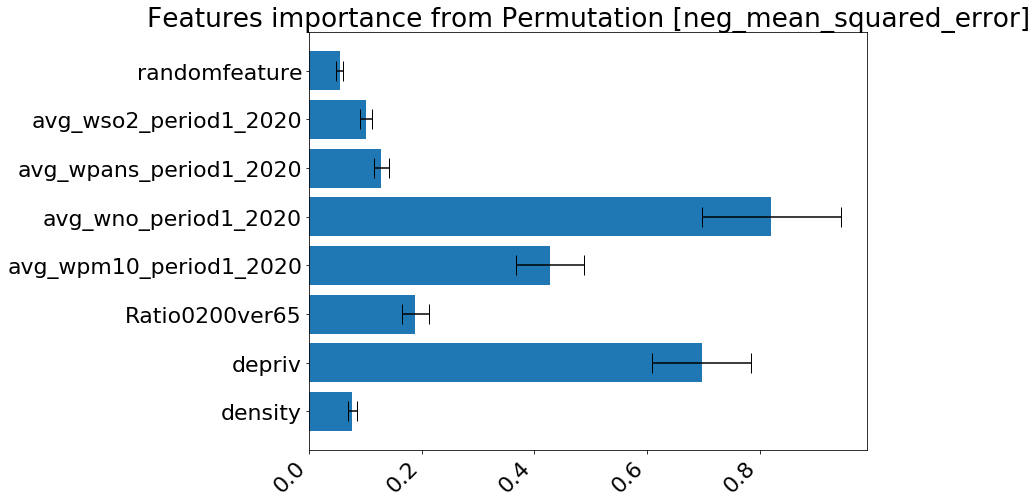

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03517 +/- 0.00386
Feature:                         depriv, Score: 0.31896 +/- 0.04034
Feature:                 Ratio0200ver65, Score: 0.08645 +/- 0.01107
Feature:         avg_wpm10_period1_2020, Score: 0.19576 +/- 0.02742
Feature:           avg_wno_period1_2020, Score: 0.37549 +/- 0.05641
Feature:         avg_wpans_period1_2020, Score: 0.05859 +/- 0.00617
Feature:          avg_wso2_period1_2020, Score: 0.04660 +/- 0.00488
Feature:                  randomfeature, Score: 0.02493 +/- 0.00276


<Figure size 432x288 with 0 Axes>

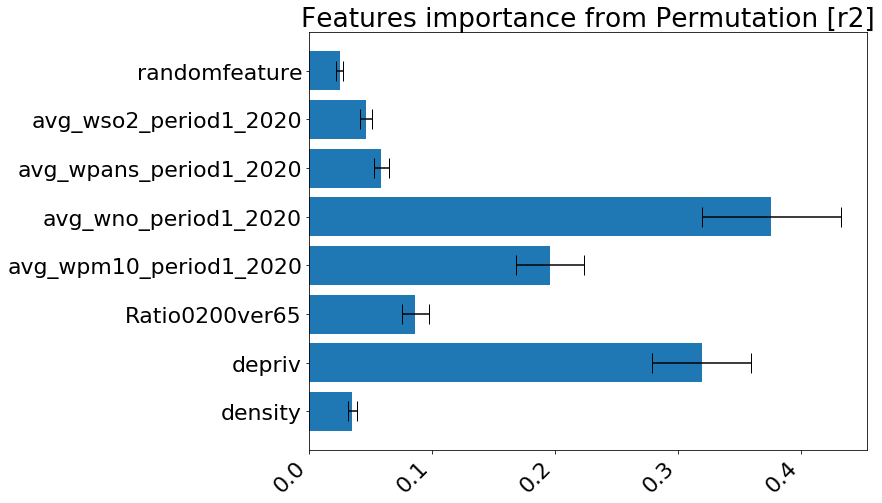

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01688 +/- 0.03697
Feature:                         depriv, Score: 0.26477 +/- 0.14108
Feature:                 Ratio0200ver65, Score: -0.01751 +/- 0.09742
Feature:         avg_wpm10_period1_2020, Score: 0.12590 +/- 0.18076
Feature:           avg_wno_period1_2020, Score: 0.26682 +/- 0.16252
Feature:         avg_wpans_period1_2020, Score: -0.04784 +/- 0.04961
Feature:          avg_wso2_period1_2020, Score: 0.03096 +/- 0.07350
Feature:                  randomfeature, Score: -0.05369 +/- 0.03887


<Figure size 432x288 with 0 Axes>

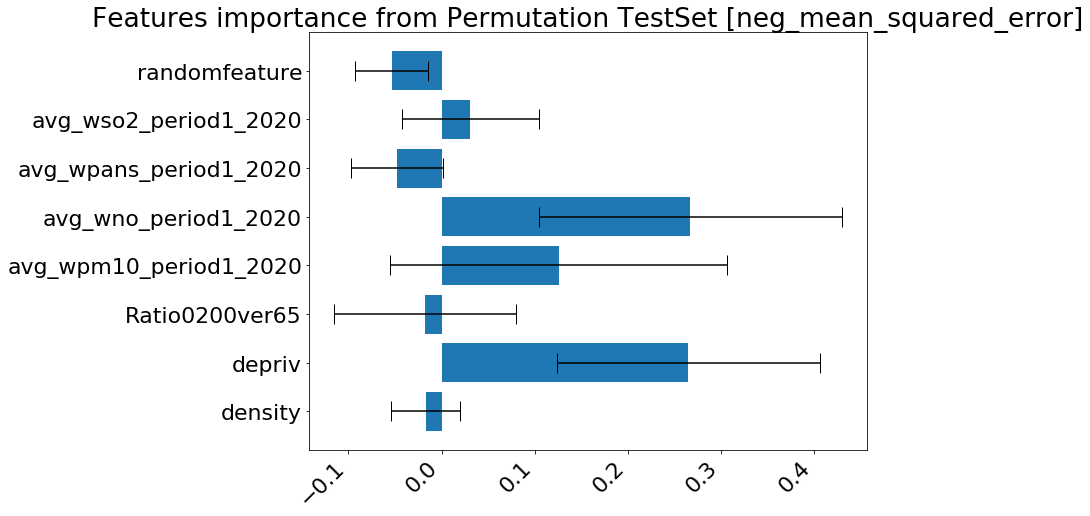

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00904 +/- 0.01980
Feature:                         depriv, Score: 0.14177 +/- 0.07554
Feature:                 Ratio0200ver65, Score: -0.00938 +/- 0.05216
Feature:         avg_wpm10_period1_2020, Score: 0.06741 +/- 0.09678
Feature:           avg_wno_period1_2020, Score: 0.14287 +/- 0.08702
Feature:         avg_wpans_period1_2020, Score: -0.02561 +/- 0.02656
Feature:          avg_wso2_period1_2020, Score: 0.01658 +/- 0.03935
Feature:                  randomfeature, Score: -0.02875 +/- 0.02081


<Figure size 432x288 with 0 Axes>

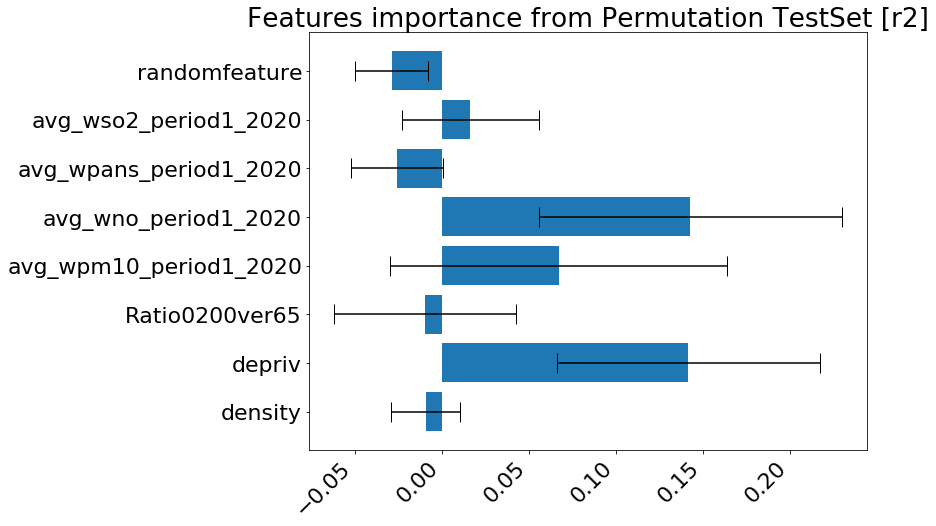

<Figure size 720x720 with 0 Axes>

((0.9442799456076055, 0.058382823699599476),
 (1.1124160323161572, 0.12518822276588892),
 0.9209904741234909,
 {'density': 0.030795077095312148,
  'depriv': 0.27931053447708587,
  'Ratio0200ver65': 0.07570554482453873,
  'avg_wpm10_period1_2020': 0.17142764320574114,
  'avg_wno_period1_2020': 0.32880895566353774,
  'avg_wpans_period1_2020': 0.051310169030741676,
  'avg_wso2_period1_2020': 0.04080889091527655,
  'randomfeature': 0.021833184787766073},
 {'density': 0.030795077095312175,
  'depriv': 0.27931053447708587,
  'Ratio0200ver65': 0.07570554482453877,
  'avg_wpm10_period1_2020': 0.17142764320574114,
  'avg_wno_period1_2020': 0.32880895566353774,
  'avg_wpans_period1_2020': 0.05131016903074172,
  'avg_wso2_period1_2020': 0.04080889091527658,
  'randomfeature': 0.021833184787766104},
 {'density': -0.030548572039074726,
  'depriv': 0.47919269923306623,
  'Ratio0200ver65': -0.03169378340178556,
  'avg_wpm10_period1_2020': 0.22786279640406867,
  'avg_wno_period1_2020': 0.4828985618709

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=besthyperF)